# BBC Kaggle Project
In this project, we’ll use a news article dataset from BBC. This dataset contains 2225 articles with each labeled as either: business, tech, politics, sport, or entertainment.

The dataset is broken into 1490 articles for training and 735 for testing (the test set must be uploaded to Kaggle for evaluation). The goal for this project is to create a model that will classify unseen news articles. Both unsupervised and surpervised learning approaches will be evaluated.

The data used in this analysis comes from here: https://www.kaggle.com/c/learn-ai-bbc/overview

Github link: https://github.com/rpforrest1/BBC_Kaggle_Project

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/BBC News Train.csv')
submission_test_df = pd.read_csv('data/BBC News Test.csv')

In [3]:
print(f'Length of training dataset: {len(df)}')
print(f'Length of testing dataset: {len(submission_test_df)}')

Length of training dataset: 1490
Length of testing dataset: 735


---

# Exploratory Data Analysis

In [4]:
print('Dataset information:')
df.info()

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


There were no null values detected in the dataset. Will also check for any articles that are unusually short (we would likely count these as null also).

In [5]:
print(f"Number of articles with less than 100 characters: {(df['Text'].apply(len) < 100).sum()}")

Number of articles with less than 100 characters: 0


In [6]:
print('Unique categories:')
print(df['Category'].unique())

Unique categories:
['business' 'tech' 'politics' 'sport' 'entertainment']


Lets take a look at the distribution of article categories. If there is some imbalance, then the modeling approach will have to change to accommodate.

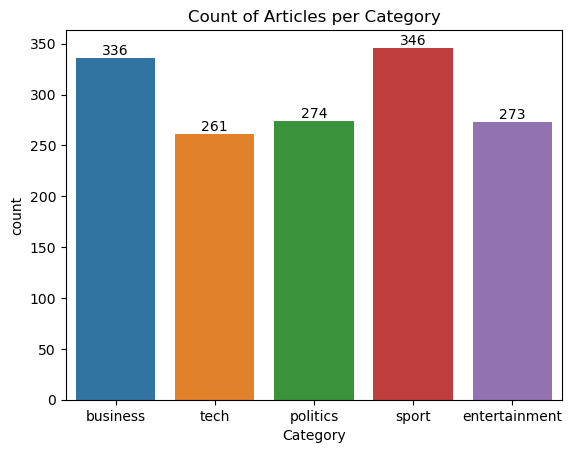

In [7]:
ax = sns.countplot(df, x='Category')
plt.title('Count of Articles per Category')
plt.bar_label(ax.containers[0])
plt.show()

From the plot above, we can see that the business and sport categories are over represented. The modeling approach won't be changed due to these results, but will be kept in mind as something to potentially account for.

A typical step thats applied in NLP is stop word removal. Stop words are not considered important and are typically high is frequency. Typical stop words in English are: 'a', 'the', 'of', 'to', 'at', etc.. These stop words will be removed as a preprocessing step.

In [8]:
def process_stopwords(dataframe):
    """
    dataframe: the pandas dataframe to remove the stopwords for.
    Will automatically remove it from the "Text" column.
    """
    
    #These stopwords are provided by the nltk package
    en_stopwords = stopwords.words('english')
    
    #Will also add any other unimportant characters that may appear as an entire word.
    en_stopwords = en_stopwords + ['', '-', '.']
    
    def remove_stopwords(text):
        return ' '.join([s for s in text.split(' ') if s not in en_stopwords])
    
    dataframe['Text'] = dataframe['Text'].apply(remove_stopwords)

In [9]:
process_stopwords(df)

Now that the stop words are removed, we can create the word embedding using the TF-IDF technique. TF-IDF stands for term frequency - inverse document frequency. TF-IDF values are between 0 and 1 with a higher score meaning that the word is considered more significant.

Term Frequency (TF) is calculated as: [count of term in the document] / [number of words in the document]

Inverse Document Frequency (IDF) is calculated as: log [ (1 + [number of documents]) / (1 + [count of documents the term appears in]) ] + 1

In [10]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df['Text'])

In [11]:
features = pd.DataFrame(tfidf.todense(), columns=vectorizer.get_feature_names_out())
display(features)

,00,000,0001,000bn,000m,000th,001,001and,001st,0051,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.022885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.019135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0.0,0.031685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1486,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1487,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1488,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that we have the TF-IDF values, lets see which terms have the highest total TF-IDF per category.

In [12]:
joined_features = df[['Category']].join(features)
joined_features = joined_features.replace(0,np.NaN)
category_summed_tfidf = joined_features.groupby('Category').sum()
category_summed_tfidf.fillna(0, inplace=True)

In [13]:
def get_largest_tfidf_terms(array, n=5):
    """
    array: tfidf array to sort
    n: number of terms to return
    """
    #Top n unsorted indices with largest values
    ind = np.argpartition(array, -n)[-n:]
    
    #Sorts indices
    return ind[np.argsort(array[ind])][::-1]

In [14]:
feature_columns = category_summed_tfidf.columns

for category in category_summed_tfidf.index:
    sorted_ind = get_largest_tfidf_terms(category_summed_tfidf.loc[category].values)
    print(f'Category: {category}')
    print(category_summed_tfidf.loc[category][feature_columns[sorted_ind]])
    print(' ')

Category: business
said       13.326727
us         10.782724
growth      9.654545
economy     8.772872
bank        8.326410
Name: business, dtype: float64
 
Category: entertainment
film      19.829240
best      11.666112
music      7.875985
said       7.376220
awards     7.364590
Name: entertainment, dtype: float64
 
Category: politics
mr          21.024520
labour      16.359353
said        15.997499
election    14.545260
blair       14.093918
Name: politics, dtype: float64
 
Category: sport
england    11.467101
game       10.826426
win         9.276456
said        9.159802
cup         8.307849
Name: sport, dtype: float64
 
Category: tech
people      10.812944
mobile      10.386262
said        10.002426
software     8.426272
users        7.987058
Name: tech, dtype: float64
 


When looking across the categories, we can see that most of the results make sense. One would expect within a business article, for words like 'us', 'growth' and 'economy' to be popular. Within the entertainment category, words like 'film' and 'music' would be highly likely. Upon closer inspection of these results, the word 'said' doesn't completely make sense as a word that would specifically belong to a category. It behaves similarily to a type of stop word, but until more is learned, this will be left alone.

---

# Modeling - Unsupervised Approach

## NMF Initial Training
A Non-Negative Matrix Factorization model will be created as a first pass. Since there are 5 article categories to predict, there will be 5 components to solve for in the NMF model. The initial model will be created using the sklearn defaults for NMF.

In [15]:
np.random.seed(4)
nmf = NMF(n_components=5, random_state=4)
factored_x_train = nmf.fit_transform(tfidf)
print(factored_x_train)

[[0.00095616 0.03806007 0.00611712 0.00409871 0.05303979]
 [0.         0.         0.         0.         0.19922213]
 [0.01243727 0.02107114 0.02796953 0.00060955 0.11679361]
 ...
 [0.0064503  0.         0.00242438 0.01271762 0.15459544]
 [0.         0.         0.2271678  0.00351922 0.0199296 ]
 [0.00036122 0.         0.09659539 0.         0.        ]]


To obtain a predicted category, the component with the highest value will be used. Afterwards, the prediucted categories need to be mapped to the original string categories. This will be done by testing every possible permutation of the mapping, and choosing the mapping that leads to the highest accuracy.

In [16]:
y_pred_train = factored_x_train.argmax(axis=1)
print('Component predictions:', y_pred_train)

Component predictions: [4 4 4 ... 4 2 2]


In [17]:
def label_permute_compare(y_true_df, y_pred):
    """
    This function is used to determine how to map the predicted categories to the original categories.
    y_true_df: dataframe with the true category labels
    y_pred: clustering label prediction output (array of integers)

    """
    str_labels = y_true_df['Category'].unique()
    n = len(str_labels)
    
    best_accuracy = 0
    best_permutation = None
    
    #Permute numbers 0 to (n-1) and have a length of n
    #Find the mapping that leads to the BEST OVERALL accuracy
    #Want to determine which label number each string label should map to.
    for perm in itertools.permutations(range(n), n):
        replacement_map = dict(zip(str_labels, perm))
        new_labels = y_true_df['Category'].replace(replacement_map)
        acc = accuracy_score(new_labels.values, y_pred)
        #Save the overall best accuracy along with its permutation
        if acc > best_accuracy:
            best_accuracy = acc
            best_permutation = np.array(perm)
    
    replacement_map = dict(zip(best_permutation, str_labels))
    
    return replacement_map, best_accuracy

In [18]:
replacement_map, test_accuracy = label_permute_compare(df, y_pred_train)
print(f'Accuracy of test set: {test_accuracy:.2%}')

Accuracy of test set: 91.48%


In [19]:
factored_x_train_categories = pd.DataFrame(factored_x_train,
                                           columns=map(lambda x: replacement_map[x], range(5)))
factored_x_train_categories.head()

,sport,politics,tech,entertainment,business
0,0.000956,0.038060,0.006117,0.004099,0.053040
1,0.000000,0.000000,0.000000,0.000000,0.199222
2,0.012437,0.021071,0.027970,0.000610,0.116794
3,0.000000,0.000000,0.228605,0.000000,0.000000
4,0.007264,0.005884,0.007406,0.008025,0.070560


Based on the permutation testing results, we see that the first component maps to the sport category, the second component maps to the politics category, and so on (reference table above). In order to know what the predicted category is, we will just take the category with the highest value.

In [20]:
predicted_train_category = factored_x_train_categories.idxmax(axis=1)
print(predicted_train_category.head(10))

0         business
1         business
2         business
3             tech
4         business
5         politics
6            sport
7    entertainment
8         business
9    entertainment
dtype: object


In [21]:
print('Confusion Matrix')
categories = df['Category'].unique()
con_mtrx = confusion_matrix(df['Category'], predicted_train_category, labels=categories)
con_mtrx = pd.DataFrame(con_mtrx, index=categories, columns=categories) 
con_mtrx.index.name = 'Actual Label'
display(con_mtrx)

Confusion Matrix


,business,tech,politics,sport,entertainment
Actual Label,,,,,
business,312,11,11,1,1
tech,3,249,0,5,4
politics,20,8,244,2,0
sport,3,0,0,341,2
entertainment,7,38,7,4,217


From the confusion matrix, we can see that when the actual category is politics, the model sometimes confuses it with business. When the actual category is entertainment, the model sometimes confuses it with tech. Those are the 2 scenarios that produced the highest error.

## Initial Testing
Will apply the same transformations as the training set and produce a final prediction. The predictions will be uploaded to Kaggle to determine the resulting accuracy.

In [22]:
#Remove stop words
process_stopwords(submission_test_df)

#Transform test set into tfidf
tfidf_test = vectorizer.transform(submission_test_df['Text'])

#Apply NMF
factored_x_test = nmf.transform(tfidf_test)

#Record highest value as the predicted category
submission_test_df['pred'] = factored_x_test.argmax(axis=1)

#Transform predicted category into the mapped string form.
#(The mapping was determined during training and will stay the same for testing.)
submission_test_df['Category'] = submission_test_df['pred'].replace(replacement_map)

#Export table to upload to Kaggle
submission_test_df[['ArticleId', 'Category']].to_csv('kaggle_nmf_sub.csv', index=False)

In [23]:
display(submission_test_df)

,ArticleId,Text,pred,Category
0,1018,qpr keeper day heads preston queens park range...,0,sport
1,1319,software watching work software monitor every ...,2,tech
2,1138,arcy injury adds ireland woe gordon arcy ruled...,0,sport
3,459,india reliance family feud heats ongoing publi...,4,business
4,1020,boro suffer morrison injury blow middlesbrough...,0,sport
...,...,...,...,...
730,1923,eu probe alitalia state aid european commissio...,4,business
731,373,u2 play grammy awards show irish rock band u2 ...,3,entertainment
732,1704,sport betting rules spotlight group mps peers ...,2,tech
733,206,alfa romeos get gm engines fiat stop making si...,4,business


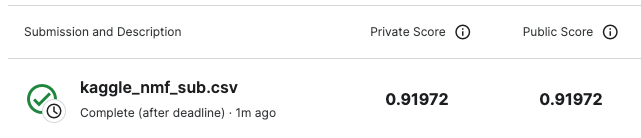

The Kaggle submission resulted in an accuracy of about 92%. I will now attempt to fine tune the model to see if a higher score is possible.

## Train with Alternate Hyper-parameters
We will now test out different hyper-parameters in the NMF model while keeping the TF-IDF static. The best hyper-parameter is determined by choosing the model with the highest accuracy.

In [24]:
def test_hyperparameters(tfidf, df):
    """
    tfidf: The TF-IDF
    df: The testing dataframe
    
    Runs hyper-parameter testing for the NMF model.
    When running the tests, the components will also need to be remapped into the string categories.
    For the model with the highest accuracy, the function returns:
        (chosen hyper-parameters, nmf object, accuracy score, replacement mapping dictionary)
    """
    #Param order will be: init, solver, beta_loss
    #Only parameter combinations that result in no errors are defined.
    param_grid = [
        ('random', 'cd', 'frobenius'),
        ('random', 'mu', 'frobenius'), ('random', 'mu', 'kullback-leibler'),
        ('nndsvd', 'cd', 'frobenius'),
        ('nndsvda', 'cd', 'frobenius'),
        ('nndsvda', 'mu', 'frobenius'), ('nndsvda', 'mu', 'kullback-leibler'),
    ]
    
    acc_scores = []
    replacement_maps = []
    nmf_objs = []
    
    for init, solver, beta_loss in param_grid:
        np.random.seed(4)
        nmf_grid = NMF(n_components=5, random_state=4, init=init, solver=solver, beta_loss=beta_loss)
        factored_grid = nmf_grid.fit_transform(tfidf)
        y_pred_grid = factored_grid.argmax(axis=1)
        grid_replacement_map, grid_accuracy = label_permute_compare(df, y_pred_grid)
        print(f'Parameters: init={init}, solver={solver}, beta_loss={beta_loss} | Accuracy = {grid_accuracy:.2%}')
        nmf_objs.append(nmf_grid)
        replacement_maps.append(grid_replacement_map)
        acc_scores.append(grid_accuracy)
    
    max_score_idx = np.array(acc_scores).argmax()
    return param_grid[max_score_idx], nmf_objs[max_score_idx], acc_scores[max_score_idx], replacement_maps[max_score_idx]

In [25]:
best_params, nmf_grid, best_accuracy, best_replacement_map = test_hyperparameters(tfidf, df)

Parameters: init=random, solver=cd, beta_loss=frobenius | Accuracy = 88.66%
Parameters: init=random, solver=mu, beta_loss=frobenius | Accuracy = 90.20%
Parameters: init=random, solver=mu, beta_loss=kullback-leibler | Accuracy = 51.81%
Parameters: init=nndsvd, solver=cd, beta_loss=frobenius | Accuracy = 91.48%
Parameters: init=nndsvda, solver=cd, beta_loss=frobenius | Accuracy = 91.48%
Parameters: init=nndsvda, solver=mu, beta_loss=frobenius | Accuracy = 91.21%
Parameters: init=nndsvda, solver=mu, beta_loss=kullback-leibler | Accuracy = 93.83%


In [26]:
print('Best hyper-parameters:', best_params)
print(f'Best resulting accuracy: {best_accuracy:.2%}')

Best hyper-parameters: ('nndsvda', 'mu', 'kullback-leibler')
Best resulting accuracy: 93.83%


In [27]:
factored_grid = nmf_grid.transform(tfidf)
factored_grid_categories = pd.DataFrame(factored_grid,
                                        columns=map(lambda x: best_replacement_map[x], range(5)))
factored_grid_categories.head()

,sport,politics,tech,entertainment,business
0,1.212661e-11,5.075217e-07,2.378640e-08,3.064037e-06,1.000580e-01
1,1.482779e-14,2.057415e-09,3.171019e-13,4.038319e-17,1.228179e-01
2,6.566498e-08,3.501638e-02,4.259976e-05,4.795973e-09,1.026043e-01
3,2.845707e-13,6.917596e-11,1.492033e-01,2.877338e-12,1.872945e-12
4,1.949311e-08,1.096467e-04,1.251408e-07,2.885661e-09,1.213518e-01


We can see that the string article names, map to the same component indices as the initial NMF model from before.

In [28]:
print('Confusion Matrix')
categories = df['Category'].unique()
predicted_grid_category = factored_grid_categories.idxmax(axis=1)
con_grid_mtrx = confusion_matrix(df['Category'], predicted_grid_category, labels=categories)
con_grid_mtrx = pd.DataFrame(con_grid_mtrx, index=categories, columns=categories)
con_grid_mtrx.index.name = 'Actual Label'
display(con_grid_mtrx)

Confusion Matrix


,business,tech,politics,sport,entertainment
Actual Label,,,,,
business,301,20,9,4,2
tech,2,244,2,8,5
politics,6,1,257,8,2
sport,0,0,0,344,2
entertainment,1,8,1,11,252


The confusion matrix results appear slightly better when compared to the initial modeling run.

## Test Best NMF Model
Obtain the accuracy of the on the Kaggle test data.

In [29]:
#Apply NMF
factored_x_test = nmf_grid.transform(tfidf_test)

#Record highest value as the predicted category
submission_test_df['pred'] = factored_x_test.argmax(axis=1)

#Transform predicted category into the mapped string form.
submission_test_df['Category'] = submission_test_df['pred'].replace(best_replacement_map)

#Export table to upload to Kaggle
submission_test_df[['ArticleId', 'Category']].to_csv('kaggle_nmf_grid_sub.csv', index=False)

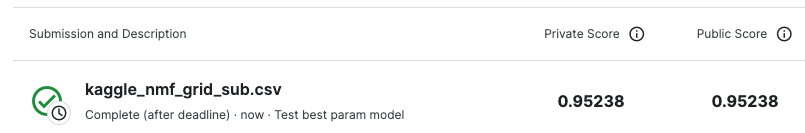

This new model resulted in a better score. Since 95% accuracy is quite good, this will be considered the final NMF model.

---

# Modeling - Supervised Approach

## Random Forest
Since there are a lot of features, a random forest model will be used. In order to determine the best random forest model, grid search will be used to determine the hyper-parameters.

In [30]:
X_train = tfidf.toarray()
y_train = pd.get_dummies(df['Category'])

In [31]:
param_grid = {'max_depth':np.linspace(20,50,6,dtype=int),
             'n_estimators':np.linspace(50,500,6,dtype=int)}
print("Grid Search Parameters:")
display(param_grid)

Grid Search Parameters:


{'max_depth': array([20, 26, 32, 38, 44, 50]),
 'n_estimators': array([ 50, 140, 230, 320, 410, 500])}

In [32]:
base_model = RandomForestClassifier(random_state=4)
grid = GridSearchCV(base_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1).fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [33]:
print(f"Best parameters found with grid search: {grid.best_params_}")
print(f"Cross-validation score using the best parameters: {grid.best_score_:.4f}")

Best parameters found with grid search: {'max_depth': 50, 'n_estimators': 320}
Cross-validation score using the best parameters: 0.7866


In [34]:
rand_model = grid.best_estimator_
y_pred_train = rand_model.predict(X_train)
print(f"Random Forest Training Accuracy (using best parameters): {accuracy_score(y_pred_train, y_train):.4f}")

Random Forest Training Accuracy (using best parameters): 1.0000


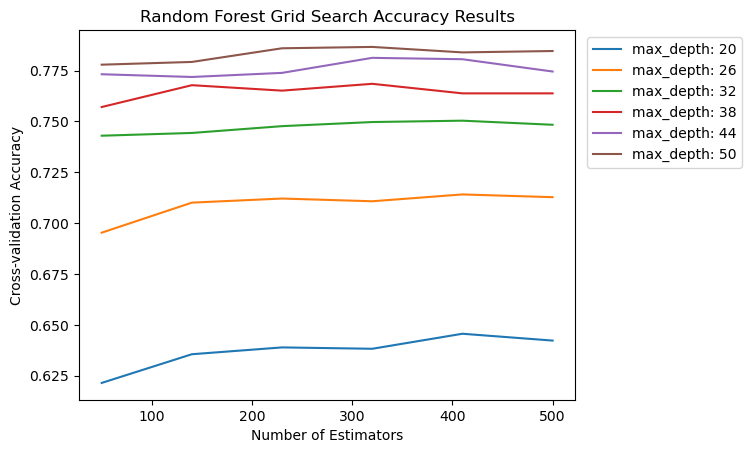

In [35]:
grid_shape = param_grid['max_depth'].shape[0], param_grid['n_estimators'].shape[0]
grid_scores = np.array(grid.cv_results_['mean_test_score']).reshape(grid_shape)
for depth in range(grid_shape[0]):
    plt.plot(param_grid['n_estimators'], grid_scores[depth], label=f"max_depth: {param_grid['max_depth'][depth]}")

plt.legend(loc=1, bbox_to_anchor=(1.35, 1))
plt.title('Random Forest Grid Search Accuracy Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-validation Accuracy')
plt.show()

Based on the grid search results, the best model would use a max_depth of **50** and n_estimatiors of **320**. Instead of doing this, I will use a max_depth of **32** with n_estimators of **50**. I chose these alternate hyperparameters since chosing higher values, do not lead to significant increases in accuracy. We can see from the graph above that accuracy doesn't increase by much after a max_depth of 32. The graph line for max_depth of 32 stays fairly consistant for all n_estimators values. Choosing these altername hyper-parameters will reduce the risk of overfitting.

## Evaluate Alternate Random Forest Model

In [36]:
np.random.seed(4)
rand_model = RandomForestClassifier(random_state=4, max_depth=32, n_estimators=50)
rand_model.fit(X_train, y_train)
y_pred_train = rand_model.predict(X_train)
print(f"Random Forest Training Accuracy (using alternate parameters): {accuracy_score(y_pred_train, y_train):.4f}")

Random Forest Training Accuracy (using alternate parameters): 0.9886


In [37]:
y_pred_test = rand_model.predict(tfidf_test.toarray())
y_pred_test = pd.DataFrame(y_pred_test, columns=y_train.columns)
submission_test_df['Category'] = y_pred_test.idxmax(axis=1)
submission_test_df[['ArticleId', 'Category']].to_csv('kaggle_rand_forrest_sub.csv', index=False)

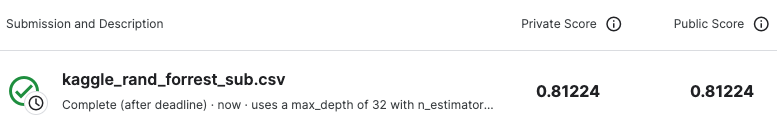

Overall, the random forest model performed fine. It was not as good as the NMF model since the accuracy is more than 10% lower.

## Further Comparisons between Unsupervised and Supervised

First, lets make smaller versions of the initial dataset that has 10, 20, and 50 percent of the data.

In [38]:
dfs = dict()
tfidfs = dict()
vectorizers = dict()
for percentage in [10, 20, 50]:
    dfs[percentage] = df.sample(frac=percentage/100, random_state=4).copy()
    process_stopwords(dfs[percentage])
    vectorizers[percentage] = TfidfVectorizer()
    tfidfs[percentage] = vectorizers[percentage].fit_transform(dfs[percentage]['Text'])

### NMF Modeling

Now, for every dataset, choose an NMF model that provides the best accuracy.

In [39]:
nmf_results = dict()
for percentage in [10, 20, 50]:
    print(f'Training NMF model using {percentage}% of the dataset.')
    #best_params, nmf_grid, best_accuracy, best_replacement_map
    nmf_results[percentage] = test_hyperparameters(tfidfs[percentage], dfs[percentage])
    print('---------------------------')

Training NMF model using 10% of the dataset.
Parameters: init=random, solver=cd, beta_loss=frobenius | Accuracy = 84.56%
Parameters: init=random, solver=mu, beta_loss=frobenius | Accuracy = 87.25%
Parameters: init=random, solver=mu, beta_loss=kullback-leibler | Accuracy = 27.52%
Parameters: init=nndsvd, solver=cd, beta_loss=frobenius | Accuracy = 85.91%
Parameters: init=nndsvda, solver=cd, beta_loss=frobenius | Accuracy = 85.91%
Parameters: init=nndsvda, solver=mu, beta_loss=frobenius | Accuracy = 87.25%
Parameters: init=nndsvda, solver=mu, beta_loss=kullback-leibler | Accuracy = 79.19%
---------------------------
Training NMF model using 20% of the dataset.
Parameters: init=random, solver=cd, beta_loss=frobenius | Accuracy = 71.48%
Parameters: init=random, solver=mu, beta_loss=frobenius | Accuracy = 71.48%
Parameters: init=random, solver=mu, beta_loss=kullback-leibler | Accuracy = 31.54%
Parameters: init=nndsvd, solver=cd, beta_loss=frobenius | Accuracy = 89.93%
Parameters: init=nndsv

- When using 10% of the dataset, the best NMF model uses these hyper-parameters: init=random, solver=mu, beta_loss=frobenius with a resulting accuracy of 87.25%.
- When using 20% of the dataset, the best NMF model uses these hyper-parameters: init=nndsvda, solver=cd, beta_loss=frobenius with a resulting accuracy of 90.27%.
- When using 50% of the dataset, the best NMF model uses these hyper-parameters: init=nndsvda, solver=mu, beta_loss=kullback-leibler with a resulting accuracy of 87.79%.

Based on these training results, the NMF model works quite well with smaller datasets. We will now take a look at the test accuracy when uploading the predictions to Kaggle.

In [40]:
tfidf_tests = dict()
for percentage in [10, 20, 50]:
    nmf_grid = nmf_results[percentage][1]
    replacement_map = nmf_results[percentage][3]
    
    #Transform test set into tfidf
    tfidf_tests[percentage] = vectorizers[percentage].transform(submission_test_df['Text'])
    
    #Apply NMF
    factored_x_test = nmf_grid.transform(tfidf_tests[percentage])

    #Record highest value as the predicted category
    submission_test_df['pred'] = factored_x_test.argmax(axis=1)

    #Transform predicted category into the mapped string form.
    submission_test_df['Category'] = submission_test_df['pred'].replace(replacement_map)

    #Export table to upload to Kaggle
    submission_test_df[['ArticleId', 'Category']].to_csv(f'{percentage}_kaggle_nmf_sub.csv', index=False)

10% of Data
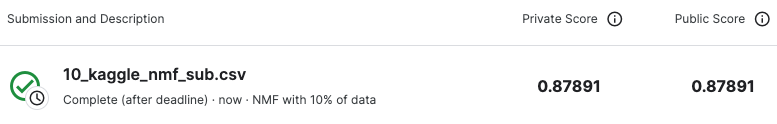

20% of Data
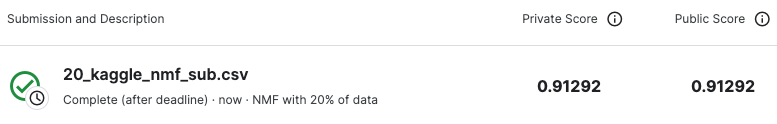

50% of Data
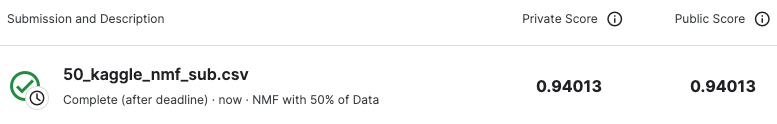

The results for the NMF model are quite good with fairly high accuracy across all data usage percentages. All of these results beat out the best surpervised learning approach as well. These model also appear to not overfit since the training and testing accuracy are close in value.

### Random Forest Modeling
Since this is only looking at how the model changes based on the percentage of data used, I will pick the best model provided by grid search for each percentage.

In [41]:
param_grid = {'max_depth':np.linspace(10,50,6,dtype=int),
             'n_estimators':np.linspace(50,300,6,dtype=int)}
print("Grid Search Parameters:")
display(param_grid)

Grid Search Parameters:


{'max_depth': array([10, 18, 26, 34, 42, 50]),
 'n_estimators': array([ 50, 100, 150, 200, 250, 300])}

In [42]:
grids = dict()
rand_models = dict()
for percentage in [10, 20, 50]:
    print(f'Training Random Forest model using {percentage}% of the dataset.')
    X_train = tfidfs[percentage].toarray()
    y_train = pd.get_dummies(dfs[percentage]['Category'])
    
    base_model = RandomForestClassifier(random_state=4)
    grids[percentage] = GridSearchCV(base_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1).fit(X_train,
                                                                                                        y_train)
    
    print(f"Best parameters found with grid search: {grids[percentage].best_params_}")
    print(f"Cross-validation score using the best parameters: {grids[percentage].best_score_:.4f}")
    rand_models[percentage] = grids[percentage].best_estimator_
    y_pred_train = rand_models[percentage].predict(X_train)
    print(f"Random Forest Training Accuracy (using best parameters): {accuracy_score(y_pred_train, y_train):.4f}")
    print('---------------------------')

Training Random Forest model using 10% of the dataset.
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters found with grid search: {'max_depth': 26, 'n_estimators': 100}
Cross-validation score using the best parameters: 0.3419
Random Forest Training Accuracy (using best parameters): 1.0000
---------------------------
Training Random Forest model using 20% of the dataset.
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters found with grid search: {'max_depth': 26, 'n_estimators': 50}
Cross-validation score using the best parameters: 0.5132
Random Forest Training Accuracy (using best parameters): 1.0000
---------------------------
Training Random Forest model using 50% of the dataset.
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters found with grid search: {'max_depth': 50, 'n_estimators': 250}
Cross-validation score using the best parameters: 0.6939
Random Forest Training Accuracy (using best parameters): 1

When training the random forest model, the amount of data used seems to heavily affect the resulting accuracy. The cross-validation scores are all rather low, which means once the predictions are uploaded to Kaggle, the accuracies will likely still be low. The training accuracy in all cases are at 100% which signals overfitting. So far, a supervised approach does not appear to be a good method.

We will now take a look at the test accuracy when uploading the predictions to Kaggle.

In [43]:
for percentage in [10, 20, 50]:
    y_pred_test = rand_models[percentage].predict(tfidf_tests[percentage].toarray())
    y_pred_test = pd.DataFrame(y_pred_test, columns=y_train.columns)
    submission_test_df['Category'] = y_pred_test.idxmax(axis=1)
    submission_test_df[['ArticleId', 'Category']].to_csv(f'{percentage}_kaggle_rand_forrest_sub.csv', index=False)

10% of Data
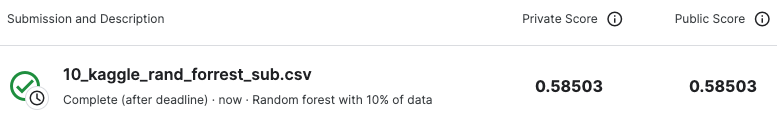

20% of Data
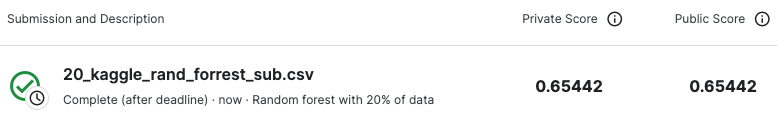

50% of Data
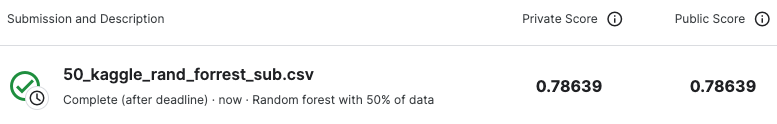

The random forest models worked better on the test set than it did during cross-validation. This model heavly depends on the amount of data that its given since the accuracy changes by a lot as the amount of data increases.

### Summary of Comparison

To summarize the comparison between supervised and unsupervised learning for this task when it comes to the amount of data used, the unsupervised models performed better than the supervised models. The unsupervised model with 10% of the data, outperformed the supervised model in all cases (even the random forest model evaluated in the prior section). The unsupervised model also appears to not overfit like the supervised model. There wasn't large differences between the training and testing accuracy for the NMF models, which indicates that the model isn't overfitting. For the random forest model, there is quite large differences between the training, cross-validation, and testing accuracies. Since the training accuracy was always near 100% as well, this indicates that the model is overfitting. My final recommendation for the best approach, would be the NMF model since all of them performed rather well.

---

# References

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

---